# Building a Spam Filter with Naive Bayes
In machine learning, Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes theorem with strong (but naive) independence assumptions between the features. In probability theory and statistics, Bayes' theorem (alternatively Bayes law or Bayes rule) describes the probability of an event, based on prior knowledge of conditions that might be related to the event.

In this notebook, I'll build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. My goal is to write a program that classifies new messages with an accuracy greater than 95%.

To train the algorithm, I'll use a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

## Data Exploration

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', header = None, names=['Label','SMS'], encoding = 'utf_8')

In [95]:
print(data.shape)
data.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [96]:
data.tail()

,Label,SMS
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [97]:
data['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

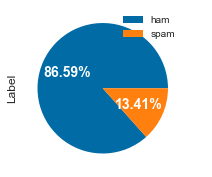

In [98]:
plt.style.use('tableau-colorblind10')
autopct = '%.2f%%'
textprops = {'color':"w",'fontsize': 14,'weight':'bold'}
data['Label'].value_counts(normalize=True).plot.pie(figsize=(3,3),autopct=autopct,textprops=textprops,legend=True)

## Training and Test Set
I'll need to split the data in to a training set and a test set. The training set will account for 80% of the data, and the test set for the remaining 20%.

In [99]:
# Randomize the dataset
data_randomized = data.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

In [100]:
# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print('Training Set')
print(training_set.shape)
#print('\n')
print('Test Set')
print(test_set.shape)

Training Set
(4458, 2)
Test Set
(1114, 2)


A sample of a population has to be a representative of the population, otherwise the results obtained can be faulty or skewed. Thus it becomes very important to check for this criterion before moving forward with the project.

In [101]:
training_set['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

Training Set


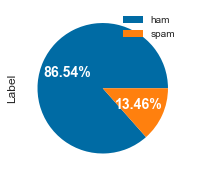

In [102]:
print('Training Set')
training_set['Label'].value_counts(normalize=True).plot.pie(figsize=(3,3),autopct=autopct,textprops=textprops,legend=True)

In [103]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

Test Set


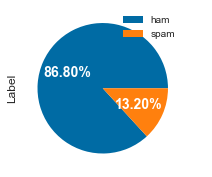

In [104]:
print('Test Set')
test_set['Label'].value_counts(normalize=True).plot.pie(figsize=(3,3),autopct=autopct,textprops=textprops,legend=True)

The `train_set` and `test_set` both have similar proportions of ham and spam messages as the original data set.

## Data Cleaning
To calculate all the probabilities required by the algorithm, I'll first need to perform a bit of data cleaning to bring the data in a format that will allow me to easily extract all the information I'll need.

### Letter Case and Punctuation
I'll begin with removing all the punctuation and standardizing text to lower case.

In [105]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [106]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating the Vocabulary
Now I'll create the vocabulary, which in this context means a list with all the unique words in the training set.

In [107]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary)) #set ingnores duplicates

### The Final Training Set
Now I'll transform the vocabulary in to a usable data format

In [108]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']): #enumerate function to get both the index and SMS message
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [109]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,sold,gotta,reacting,suffers,espe,watches,freaky,rewarding,colourful,choice,...,box61,transcribing,sipix,breathe,valuable,requires,finding,teachers,working,crazy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
training_set_usable = pd.concat([training_set, word_counts], axis=1)
training_set_usable.head()

,Label,SMS,sold,gotta,reacting,suffers,espe,watches,freaky,rewarding,...,box61,transcribing,sipix,breathe,valuable,requires,finding,teachers,working,crazy
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Building 
### Calculate Constants 

Now that I've cleaned the data and have a training set to work with I can begin building the model.

The Naive Bayes algorithm's formula requires the following terms. Precalculating them once saves will save time during model training.
- `P(spam)` - probability of spam
- `P(ham)` - probability of non-spam
- `Nspam` - number of words in spam messages
- `Nham` - number of words in non-spam messages
- `Nvocab` - number of words in vocabulary
- `Alpha` - Laplace smoothing constant

Alpha, the Laplace smoothing constant, is required because there can be certain words of the input text that only appear in spam messages and not in non-spam messages. If excluded, calculating `P(word|non-spam)` would yield 0.


In [111]:
# Isolate Spam and Ham messages
spam = training_set_usable[training_set_usable['Label']=='spam']
ham = training_set_usable[training_set_usable['Label']=='ham']

# P(Spam) and P(Ham)
p_spam = len(spam) / len(training_set_usable)
p_ham = len(ham) / len(training_set_usable)

#N_Spam
n_words_per_spam_message = spam['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

### Calculate Parameters

Now that I have the constant terms calculated, it is time to calculate the parameters 
- `P(w_i|Spam)` 
- `P(w_i|Ham)`

wi stands for each word in the vocabulary. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.These calculations are static like the ones done previously. Calculating them once will avoid meaningless calculations during training phase. 

Two separate dictionaries, one for spam and one for ham are created, mapping each word to its probability of appearing in the respective label.

In [112]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

for word in vocabulary:
    n_word_given_spam = spam[word].sum()   # spam already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

### Build Model

Now that the static components required for the model are calculated, I can build the model. The model will:

- Takes an input message (w1, w2, ..., wn).
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [113]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]   

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Needs Human Classification!')

Test the function with: 
- WINNER!! This is the secret code to unlock the money: C3421.
- Sounds good, Tom, then see u there

In [114]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [115]:
classify('Sounds good, Tom, then see u there')

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Model Testing
The preliminary test above looks good. The next step is to test the model on the test data set. Below I'll change the function to return instead of print

In [116]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'Needs Human Classification!'

With the function set to  return labels instead of printing them, I can use it to create a new column in the test set.

In [117]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [118]:
correct = 0
total = len(test_set)

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', round(correct/total,4))  

Correct: 1100
Incorrect: 14
Accuracy: 0.9874


## Conclusions

In this notebook I successfully built a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. There are 14 messages that were misclassified and require further attention, but overall the model learned the training data well and preformed well on the test set. 